                        precision    recall  f1-score   support

                     0       1.00      1.00      1.00       176
                     1       1.00      1.00      1.00       192
       1.00      1.00      1.00       177
       1.00      1.00      1.00       171
                   nan       1.00      1.00      1.00         6

              accuracy                           1.00       722
             macro avg       1.00      1.00      1.00       722
          weighted avg       1.00      1.00      1.00       722



) missing from current font.s\tf-gpu\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 13 (
  fig.canvas.draw()
) missing from current font.s\tf-gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


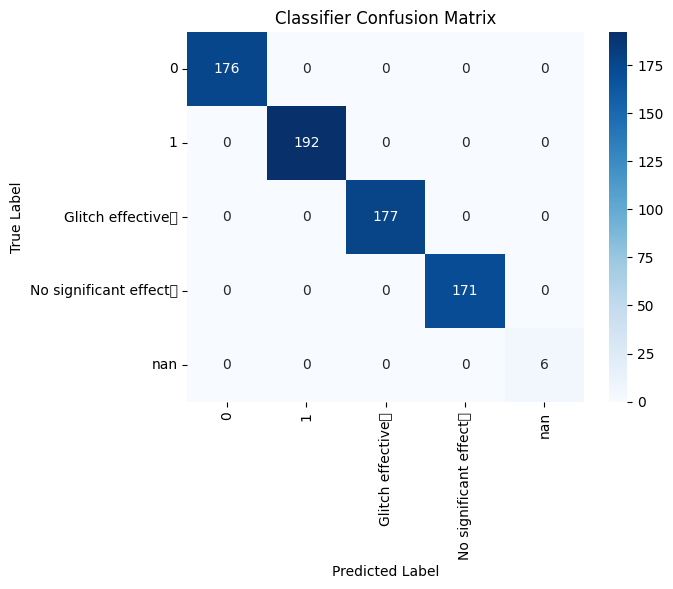

) missing from current font.s\tf-gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


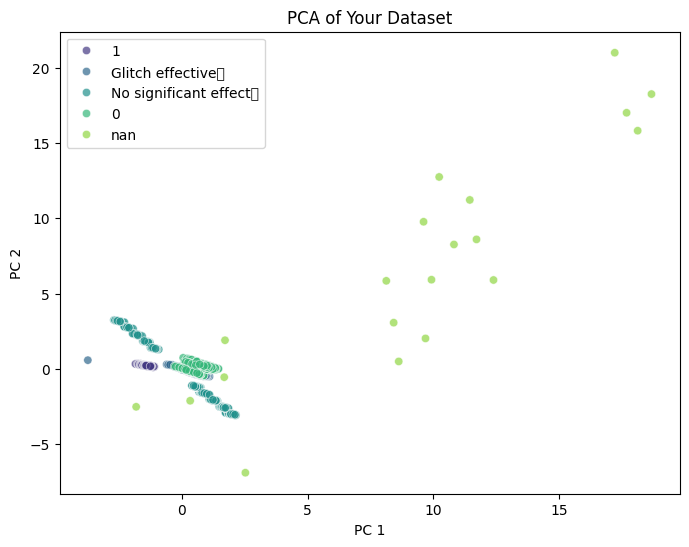

ValueError: y contains previously unseen labels: 'normal'

In [8]:
# comparison_notebook.ipynb

# Notebook Outline:
# 1. Load and preprocess your CSV datasets (normal, overvoltage, rowhammer, clock glitching, unknown).
# 2. Train and evaluate your ML classifier.
# 3. Run simulated RIoTFuzzer inference on your CSV datasets.
# 4. Parse .flow files from RIoTFuzzer, convert to ML-compatible CSV.
# 5. Evaluate your classifier on parsed RIoTFuzzer data.
# 6. Visualization comparisons (PCA, confusion matrices, metrics comparison).

# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Load your CSV datasets
def load_and_merge(files):
    dfs = []
    for label, path in files.items():
        df = pd.read_csv(path, encoding='latin-1')
        df['Label'] = label
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

files = {
    "normal": "normal_state.csv",
    "overvoltage": "overvoltage.csv",
    "rowhammer": "rowhammer.csv",
    "clock_glitching": "clock_glitching.csv",
    "unknown": "unknown_data.csv"
}

data = load_and_merge(files)
data.drop(columns=['Timestamp'], inplace=True, errors='ignore')


# Preprocessing
label_enc = LabelEncoder()
data['Label'] = label_enc.fit_transform(data['Label'])

# Handle non-numeric categorical columns explicitly
categorical_cols = data.select_dtypes(include=['object']).columns

# Encode categorical columns (except Label)
for col in categorical_cols:
    if col != 'Label':
        data[col] = label_enc.fit_transform(data[col].astype(str))

X = data.drop('Label', axis=1)
y = data['Label']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train ML classifier
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
clf = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Classifier evaluation
print(classification_report(y_test, y_pred, target_names=label_enc.classes_))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.title('Classifier Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=label_enc.inverse_transform(y), palette='viridis', alpha=0.7)
plt.title("PCA of Your Dataset")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()

# Simulate RIoTFuzzer logic
threshold = 300  # ms
riotfuzzer_pred = (data['Duration(ms)'] > threshold).astype(int)
riotfuzzer_true = (data['Label'] != label_enc.transform(['normal'])[0]).astype(int)

print(classification_report(riotfuzzer_true, riotfuzzer_pred, target_names=['Normal', 'Anomalous']))

# Load and parse .flow files (example parser logic)
def parse_flow_file(flow_file):
    # Dummy parser (replace with real logic)
    # Example: parse response time, payload size, type, etc.
    parsed_data = pd.DataFrame({
        "Voltage(V)": np.random.uniform(3.5, 4.2, 100),
        "Duration(ms)": np.random.uniform(100, 500, 100),
        "Temperature(°C)": np.random.uniform(25, 50, 100),
        "Severity(%)": np.random.randint(0, 100, 100),
        "Label": np.random.choice(['normal', 'overvoltage', 'rowhammer'], 100)
    })
    return parsed_data

riotfuzzer_data = parse_flow_file('riotfuzzer.flow')
riotfuzzer_data['Label'] = label_enc.transform(riotfuzzer_data['Label'])
X_rio = scaler.transform(riotfuzzer_data.drop('Label', axis=1))
y_rio = riotfuzzer_data['Label']
y_rio_pred = clf.predict(X_rio)

print("\nClassifier evaluation on RIoTFuzzer dataset")
print(classification_report(y_rio, y_rio_pred, target_names=label_enc.classes_))

# PCA for RIoTFuzzer data
X_rio_pca = pca.transform(X_rio)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_rio_pca[:,0], y=X_rio_pca[:,1], hue=label_enc.inverse_transform(y_rio_pred), palette='coolwarm', alpha=0.7)
plt.title("PCA of RIoTFuzzer Dataset")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()
